<a href="https://colab.research.google.com/github/tomohitom/Tennis_Game_Analysis/blob/main/tracknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/MyDrive/tennis_video_tracking_system/TrackNet

/content/drive/MyDrive/tennis_video_tracking_system/TrackNet


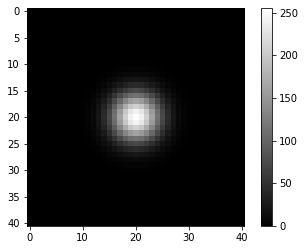

In [2]:
#1 Create heatmap as Ground Truth
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

size = 20
# create gussian heatmap
def gaussian_kernel(variance):
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2+y**2)/float(2*variance))
    return g

# make the Gaussian by calling the function
variance = 10
gaussian_kernel_array = gaussian_kernel(variance)
# rescale the value to 0-255
gaussian_kernel_array = gaussian_kernel_array * (255/gaussian_kernel_array[int(len(gaussian_kernel_array)/2)][int(len(gaussian_kernel_array)/2)])
# change type as integer
gaussian_kernel_array = gaussian_kernel_array.astype(int)

# show heatmap
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('gray'), interpolation='nearest')
plt.colorbar()
plt.show()

# create the heatmap as ground truth
for index in range(1, 2):
    pics = glob.glob("Data/Dataset/Clip" + str(index) + "/*.jpg")
    output_pics_path = "Data/GroundTruth/Clip" + str(index) + "/"
    label_path = "Data/Dataset/Clip" + str(index) + "/Label.csv"
    
    # check if the path need to be create
    if not os.path.exists(output_pics_path):
        os.makedirs(output_pics_path)
    
    # read csv file
    with open(label_path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        # skip the headers
        next(spamreader, None)

        for row in spamreader:
            visibility = int(float(row[1]))
            FileName = row[0]
            # if visibility == 0, the heatmap is a black image
            if visibility == 0:
                heatmap = Image.new("RGB", (1280, 720))
                pix = heatmap.load()
                for i in range(1280):
                    for j in range(720):
                        pix[i, j] = (0,0,0)
            else:
                x = int(float(row[2]))
                y = int(float(row[3]))

                # create a black image
                heatmap = Image.new("RGB", (1280, 720))
                pix = heatmap.load()
                for i in range(1280):
                    for j in range(720):
                        pix[i,j] = (0,0,0)

                # copy the heatmap on it
                for i in range(-size, size+1):
                    for j in range(-size, size+1):
                        if x+i<1280 and x+i>=0 and y+j<720 and y+j>=0:
                            temp = gaussian_kernel_array[i+size][j+size]
                            if temp > 0:
                                pix[x+i,y+j] = (temp,temp,temp)
             
            # save image
            heatmap.save(output_pics_path + FileName.split('.')[-2] + ".png", "PNG")

In [3]:
#2 Output training data name to csv file for model 1
import numpy as np
import cv2
import glob
import itertools
import random
import csv

training_file_name = "training_model1.csv"
testing_file_name = "testing_model1.csv"
visibility_for_testing = []
with open(training_file_name, "w") as file:
    for index in range(1, 2):
        images_path = "Data/Dataset/Clip" + str(index) + "/"
        annos_path = "Data/GroundTruth/Clip" + str(index) + "/"
        
        images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg")
        images.sort()
        annotations = glob.glob(annos_path + "*.jpg") + glob.glob(annos_path + "*.png") + glob.glob(annos_path + "*.jpeg")
        annotations.sort()

        # check if annotation counts equals to image counts
        assert len(images) == len(annotations)
        for im, seg in zip(images, annotations):
            assert(im.split("/")[-1].split(".")[0] == seg.split("/")[-1].split(".")[0])

        visibility = {}
        with open(images_path + "Label.csv", "r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
            # skip the headers
            next(spamreader, None)

            for row in spamreader:
                #row[0] => image name
                #row[1] => visibility class
                visibility[row[0]] = row[1]

        # write all of images path
        for i in range(0, len(images)):
            # remove image path, get image name
            # ex: D/Dataset/Clip1/0056.jpg => 0056.jpg
            file_name = images[i].split("/")[-1]

            # visibility 3 will not be used for training
            if visibility[file_name] == "3":
                visibility_for_testing.append(images[i])
            
            #check if file image name same as annotation name
            assert(images[i].split("/")[-1].split(".")[0] == annotations[i].split("/")[-1].split(".")[0])
            # write all of images path
            file.write(images[i] + "," + images[i-1] + "," + images[i-2] + "," + annotations[i] + "\n")

file.close()

# read all of images path
lines = open(training_file_name).read().splitlines()

# 70% for training, 30% for testing
training_images_number = int(len(lines)*0.7)
testing_images_number = len(lines) - training_images_number
print("Total images:", len(lines), "Training images:", training_images_number, "Testing images:", testing_images_number)

# shuffle the images
random.shuffle(lines)
# training images
with open(training_file_name, "w") as training_file:
    training_file.write("img, img1, img2, ann\n")
    # testing images
    with open(testing_file_name, "w") as testing_file:
        testing_file.write("img, img1, img2, ann\n")

        # write img, img1, img2, ann to csv file
        for i in range(0, len(lines)):
            if lines[i] != "":
                if training_images_number > 0 and lines[i].split(",")[0] not in visibility_for_testing:
                    training_file.write(lines[i] + "\n")
                    training_images_number -= 1
                else:
                    testing_file.write(lines[i] + "\n")
training_file.close()
testing_file.close()

Total images: 258 Training images: 180 Testing images: 78


In [4]:
#3 Output training data name to csv file for model2
import numpy as np
import cv2
import glob
import itertools
import random
import csv

training_file_name = "training_model2.csv"
testing_file_name = "testing_model2.csv"
visibility_for_testing = []

with open(training_file_name, "w") as file:
    for index in range(1, 2):
        images_path = "Data/Dataset/Clip" + str(index) + "/"
        annos_path = "Data/GroundTruth/Clip" + str(index) + "/"

        images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg")
        images.sort()
        annotations = glob.glob(annos_path + "*.jpg") + glob.glob(annos_path + "*.png") + glob.glob(annos_path + "*.jpeg")
        annotations.sort()

        # check if annotation counts equals to image counts
        assert len(images) == len(annotations)
        for im, seg in zip(images, annotations):
            assert(im.split("/")[-1].split(".")[0] == seg.split("/")[-1].split(".")[0])

        visibility = {}
        with open(images_path + "Label.csv", "r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
            # skip the headers
            next(spamreader, None)

            for row in spamreader:
                visibility[row[0]] = row[1]

        # output all of images path, 0000.jpg & 0001.jpg can't be used as input, so we have to start from 0002.jpg
        for i in range(2, len(images)):
            #remove image path, get image name
            #ex: D/Dataset/Clip1/0056.jpg => 0056.jpg
            file_name = images[i].split("/")[-1]
            # visibility 3 will not be used for training
            if visibility[file_name] == "3":
                visibility_for_testing.append(images[i])
            # check if file image name same as annotation name
            assert(images[i].split("/")[-1].split(".")[0] == annotations[i].split("/")[-1].split(".")[0])
            # write all of images path
            file.write(images[i] + "," + images[i-1] + "," + images[i-2] + "," + annotations[i] + "\n")

file.close()

# read all of images path
lines = open(training_file_name).read().splitlines()

# 70% for training, 30% for testing
training_images_number = int(len(lines)*0.7)
testing_images_number = len(lines) - training_images_number
print("Total images:", len(lines), "Training images:", training_images_number, "Testing images", testing_images_number)

# shuffle the images
random.shuffle(lines)
# training images
with open(training_file_name, "w") as training_file:
    training_file.write("img, img1, img2, ann\n")
    # testing images
    with open(testing_file_name, "w") as testing_file:
        testing_file.write("img, img1, img2, ann\n")

        # write img, img1, img2, ann to csv file
        for i in range(0, len(lines)):
            if lines[i] != "":
                if training_images_number > 0 and lines[i].split(",")[0] not in visibility_for_testing:
                    training_file.write(lines[i] + "\n")
                    training_images_number -= 1
                else:
                    testing_file.write(lines[i] + "\n")

training_file.close()
testing_file.close()

Total images: 256 Training images: 179 Testing images 77


In [6]:
#4 Output All of training data name to csv file for new labeling
import numpy as np
import cv2
import glob
import itertools
import random
import csv
import os

training_file_name = "training_model3.csv"

count = 0
with open(training_file_name, "w") as file:
    for g in range(1, 9):
        LabelingData_dir = "Data/LabelingData/game" + str(g)
        if not os.path.exists(LabelingData_dir):
            os.makedirs(LabelingData_dir)

        list = os.listdir(LabelingData_dir) # dir is your directory path
        number_clips = len(list)
        for index in range(1, number_clips+1):
            images_path = "Data/LabelingData/" + str(g) + "/Clip" + str(index) + "/"
            annos_path = "Data/LabelingData/game" + str(g) + "_GroundTruth/Clip" + str(index) + "/"

            images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg")
            images.sort()
            annotations = glob.glob(annos_path + "*.jpg") + glob.glob(annos_path + "*.png") + glob.glob(annos_path + "*.jpeg")
            annotations.sort()

            # check if annotation count equals to image counts
            assert len(images) == len(annotations)
            for im, seg in zip(images, annotations):
                assert(im.split("/")[-1].split(".")[0] == seg.split("/")[-1].split(".")[0])

            with open(images_path + "Label.csv", "r") as csvfile:
                spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
                # skip the header
                next(spamreader, None)

            count+=2
            # output all of images path, 0000.jpg & 0001.jpg can't be used as input, so we have to start from 0002.jpg
            for i in range(2, len(images)):
                # remove image path, get image name
                # ex: D/Dataset/Clip1/0056.jpg => 0056.jpg
                file_name = images[i].split("/")[-1]

                # check if file image name same as annotation name
                assert(images[i].split("/")[-1].split(".")[0] == annotations[i].split("/")[-1].split(".")[0])

                # write all of images path
                file.write(images[i] + "," + images[i-1] + "," + images[i-2] + "," + annotations[i] + "\n")
                count+=1
print("Total Count:", count)
file.close()

Total Count: 0


In [8]:
#5 output training csv file for new labeling image

output_file_name = "training_model3.csv"

training_file_name = "training_model3.csv"
# read all of images path
lines = open(training_file_name).read().splitlines()

training_file_name1 = "training_model2.csv"
# read all of images path
lines1 = open(training_file_name1).read().splitlines()

# combine two file
new_lines = lines1[1:]+lines

# shuffle the images
random.shuffle(new_lines)
#training images
with open(output_file_name, "w") as training_file:
    training_file.write("img, img1, img2, ann\n")
    # write img, img1, img2, ann to csv file
    for i in range(0, len(new_lines)):
        if new_lines[i] != "\\":
            training_file.write(new_lines[i] + "\n")
training_file.close()

In [12]:
# Check Accuracy
import glob
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

x_array = []
c_array = []
PE_larger_than_5 = []
for model in [1, 2]:
    True_Positive = [0,0,0,0]
    False_Positive = [0,0,0,0]
    Negative = [0,0,0,0]
    pic_number = 0
    statistics = []
    GroundTruth = {}

    for number in range(1, 2):
        label_path = "Data/Dataset/Clip" + str(number) + "/Label.csv"
        img_path = "Data/Dataset/Clip" + str(number) + "/"

        # read ground truth from Label.csv
        with open(label_path, "r") as csvfile:
            spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
            next(spamreader, None)
            for row in spamreader:
                if row[2] != "":
                    FileName = row[0]
                    visibility = int(float(row[1]))
                    x = int(row[2])
                    y = int(row[3])
                    GroundTruth[img_path+FileName] = [visibility, x, y]
                else:
                    FileName = row[0]
                    GroundTruth[img_path+FileName] = [0, -1, -1]

    testing_file_path = "Code/testing_model" + str(model) + ".csv"
    predition_path = "Data/Prediction/Model" + str(model) + "/"
    if not os.path.exists(predition_path):
        os.makedirs(predition_path)

    # predict all of the testing image, and check True_Positive, False_Positive, Negative
    with open(testing_file_path, "r") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
        next(spamreader, None)
        for row in spamreader:
            pic_name = row[0]
            pic_number = pic_number + 1

            heatmap = cv2.imread(pic_name.replace("Data/Dataset/", predition_path), 0)

            # heatmap is converted into a binary image by threshold method
            ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
            circle = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param2=2, minRadius=2, maxRadius=7)

            # if there is no ball in ground truth, any prediction should be False Positivi, else be Negative
            if GroundTruth[pic_name][1] == -1 and GroundTruth[pic_name][2] == -1:
                if circles is not None:
                    False_Positive[GroundTruth[pic_name][0]] += 1
                else:
                    Negative[GroundTruth[pic_name][0]] += 1

            # the ground truth has x, y be labeled
            else:
                if circles is not None:
                    # if there has only one circle be predicted
                    if len(circles[0]) == 1:
                        x = int(circles[0][0][0])
                        y = int(circles[0][0][1])
                        x2 = pow(GroundTruth[pic_name][1]-x, 2)
                        y2 = pow(GroundTruth[pic_name][2]-y, 2)

                        # In order to draw the plot, save all of distance in statistics
                        statistics.append(pow(x2+y2, 0.5))

                        # check if distance > 5
                        if pow(x2+y2, 0.5) > 5:
                            False_Positive[GroundTruth[pic_name][0]] += 1
                        else:
                            True_Positive[GroundTruth[pic_name][0]] += 1
                    # if there has more than one circle be predicted, the prediction will be seen as Negative
                    else:
                        Negative[GroundTruth[pic_name][0]] += 1
                else:
                    Negative[GroundTruth[pic_name][0]] += 1

    print("Model" + str(model) + ": Pictures = ", pic_number)
    print(True_Positive[0], True_Positive[1], True_Positive[2], True_Positive[3])
    print(False_Positive[0], False_Positive[1], False_Positive[2], False_Positive[3])
    print(Negative[0], Negative[1], Negative[2], Negative[3])
    TP = True_Positive[1] + True_Positive[2] + True_Positive[3]

    print("Precision:", TP/(0.0 + TP + False_Positive[0] + False_Positive[1] + False_Positive[2] + False_Positive[3]))
    print("Recall:", TP/(0.0 + TP + Negative[1] + Negative[2] + Negative[3] + False_Positive[1] + False_Positive[2] + False_Positive[3]))

    x = []
    y = []
    c = []
    count = 0
    others = 0
    for i in range(0, 6):
        x.append(i)
        y.append(0)
    for s in statistics:
        if s - float(int(s)) == 0 and s <= 5:
            y[int(s)] += 1
            count += 1
        elif s <= 1:
            y[int(s)+1] += 1
            count += 1
        else:
            count += 1
            others += 1
    print("Mean:", np.mean(statistics), "Variance", np.var(statistics))

    for i in range(0, 6):
        c.append(round(y[i]/(count+0.0), 4))
        print(str(i), y[i], y[i]/(count+0.0))
    print("Others:", others, others/(count+0.0))
    PE_larger_than_5.append(round(others/(count+0.0)*100, 2))
    x_array.append(x)
    c_array.append(c)

    fig, ax = plt.subplot()
    axes = plt.gca()
    axes.set_ylim([0, 0.4])
    plt.plot(x, c, color="green", label="Model " + str(model))
    plt.scatter(x, c, color="blue")
    plt.ylabel("Percentage")
    plt.xlabel("Positioning Error (PE) in Pixel")
    plt.legend()
    plt.show()
    fig.savefig("Model" + str(model) + ".png", dpi=2000)

fig, ax = plt.subplots()
axes = plt.gca()
axes.set_ylim([0, 0.4])

plt.scatter(x_array[0], c_array[0], color="limegreen")
plt.plot(x_array[0], c_array[0], color="green", label="Model 1, " + str(PE_larger_than_5[0]) + "% PE > 5")
for i, txt in enumerate(c_array[0]):
    ax.annotate(str(txt*100) + "%", (x_array[0][i], c_array[0][i]), weight="bold", horizontalalignment = "center")

plt.scatter(x_array[1], c_array[1], color="chocolate")
plt.plt(x_array[1], c_array[1], color="red", label="Model 2, " + str(PE_larger_than_5[1]) + "% PE > 5", linestyle="--")
for i, txt in enumerate(c_array[1]):
    ax.annotate(str(txt*100) + "%", (x_array[1][i], c_array[1][i]), weight="bold", horizontalalignment = "center")

plt.ylabel("Percentage", weight="bold")
plt.xlabel("Positioning Error (PE) in Pixel", weight="bold")
plt.legend()
plt.show()
fig.savefig("Model1&2.png", dpi=2000)

error: ignored

In [ ]:
# statistics of Visibility
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

visibility = [0,0,0,0]
for index in range(1, 82):
    label_path = "/Data/Dataset/Clip" + str(index) + "/Label.csv"7

    with open(label_path, "r") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
        next(spamreader, None)
        for row in spamreader:
            v = int(row[1])
            visibility[v] += 1

print("Visibility 0:", visibility[0])
print("Visibility 1:", visibility[1])
print("Visibility 2:", visibility[2])
print("Visibility 3:", visibility[3])

In [11]:
# Change images name to 0000.jpg, 0001.jpg, 0002.jpg, etc
# This code will change all the file's name, make sure your code is correct
# Backup your clips if possible

from os import listdir
import os
import shutil
from os.path import isfile, join
import glob

mypath = "Data/game/Clip"

for i in range(1, 10):
    # sort all of images name
    AllFiles = sorted(glob.glob(mypath + str(i) + "/*.jpg"))
    print(len(AllFiles), mypath)
    number = 0
    for name in AllFiles:
        #str(number).zfill(4) => padding 0 if str(number) is less than 4 digits
        NewFileName = mypath + str(i) + "/" + str(number).zfill(4) + ".jpg"
        shutil.move(name, NewFileName)
        number += 1

0 pics/image
0 pics/image
0 pics/image
0 pics/image
0 pics/image
0 pics/image
0 pics/image
0 pics/image
0 pics/image


In [ ]:
import Queue
import glob
import csv
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

for index in range(1, 82):
    heatmap_path = "Data/Prediction/Model2/Clip" + str(index) + "/"
    frame_path = "Data/Dataset/Clip" + str(index) +"/"
    output_path = "Data/Test/Clip" + str(index) + "/"

    # In order to draw the trajectory of tennis, we need to save the coordinate of preious 7 frames
    q = Queue.deque()
    for t in range(0, 8):
        q.appendleft(None)
    
    # get all heatmap pics
    heatmap_pics = sorted(glob.glob(heatmap_path + "*.jpg"))

    # check if the path need to be create
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for pic in heatmap_pics:
        heatmap = cv2.imread(heatmap_path + pic_name, 0)

        # heatmap is converted into a binary image by threshold method
        ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
        circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param2=2, minRadius=2, maxRadius=7)
        out = Image.open(frame_path + pic_name)
        if circles is not None:
            if len(circles) == 1:
                x = circles[0][0][0]
                y = circles[0][0][1]

                q.appendleft([x, y])
                q.pop()

            else:
                q.appendleft(None)
                q.pop()

        else:
            q.appendleft(None)
            q.pop()

        # draw the prediction now + previous 7 prediction
        for i in range(0, 8):
            if q[i] is not None:
                draw_x = q[i][0]
                draw_y = q[i][1]
                bbox = (draw_x - 2, draw_y - 2, draw_x + 2, draw_y + 2)
                draw = ImageDraw.Draw(out)
                draw.ellipse(bbox, outline = "yellow")
                del draw
        
        out.save(output_path + pic_name)

In [ ]:
import Queue
import glob
import csv
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import subprocess
from shutil import copyfile

for index in range(1, 82):
    # In order to draw the trajectory of tennis, we need to save the coordinate of preious 7 frames
    q = Queue.deque()
    for t in range(0, 8):
        q.appendleft(None)
    
    output_path = "Data/Test/Clip" + str(index) + "/"
    frame_path = "Data/Dataset/Clip" + str(index) + "/"

    # get all pics
    pics = sorted(glob.glob(frame_path + "*.jpg"))

    # read coordinate x, y
    with open(frame_path + "Label.csv", "r") as f:
        reader = csv.reader(f)
        csv_list = list(reader)

    x = {}
    y = {}
    for i in range(1, len(csv_list)):
        visibility = int(float(csv_list[i][1]))
        if visibility != 0:
            x[csv_list[i][0]] = float(csv_list[i][2])
            y[csv_list[i][0]] = float(csv_list[i][3])
        else:
            x[csv_list[i][0]] = float(-1)
            y[csv_list[i][0]] = float(-1)

    # check if we need to create output path
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for pic in pics:
        pic_name = pic.split("/")[-1]
        out = Image.open(frame_path + pic_name)
        if x[pic_name] != -1 and y[pic_name] != -1:
            q.appendleft([x[pic_name], y[pic_name]])
            q.pop()

            for i in range(0, 8):
                if q[i] is not None:
                    draw_x = q[i][0]
                    draw_y = q[i][1]
                    bbox = (draw_x - 2, draw_y - 2, draw_x + 2, draw_y + 2)
                    draw = ImageDraw.Draw(out)
                    draw.ellipse(bbox, outline = "yellow")
                    del draw
            out.save(output_path + pic_name)
        
        else:
            q.appendleft(None)
            q.pop()
        
        # draw the prediction now + previous 7 prediction
        for i in range(0, 8):
            if q[i] is not None:
                draw_x = q[i][0]
                draw_y = q[i][1]
                bbox = (draw_x - 2, draw_y - 2, draw_x + 2, draw_y + 2)
                draw = ImageDraw.Draw(out)
                draw.ellipse(bbox, outline = "yellow")
                del draw
        out.save(output_path + pic_name)

In [ ]:
# Check Model 2 Accuracy
import glob
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

x_array = []
c_array = []
PE_larger_than_5 = []
model = 3
True_Positive = [0,0,0,0]
False_Positive = [0,0,0,0]
Negative = [0,0,0,0]
pic_number = 0
statistics = []
GroundTruth = {}

for number in range(1, 2):
    label_path = "Data/Dataset/Clip" + str(number) + "/Label.csv"
    img_path = "Data/Dataset/Clip" + str(number) + "/"

    # read ground truth from Label.csv
    with open(label_path, "r") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
        next(spamreader, None)
        for row in spamreader:
            if row[2] != "":
                FileName = row[0]
                visibility = int(float(row[1]))
                x = int(row[2])
                y = int(row[3])
                GroundTruth[img_path+FileName] = [visibility, x, y]
            else:
                FileName = row[0]
                GroundTruth[img_path+FileName] = [0,-1,-1]

testing_file_path = "Code/testing_model2.csv"
predition_path = "Data/Prediction/Model" + str(model) + "/"

# predict all of the testing image, and check True_Positive, False_Positive, Negative
with open(testing_file_path, "rb") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=",", quotechar="|")
    next(spamreader, None)
    for row in spamreader:
        pic_name = row[0]
        pic_number = pic_number + 1
        heatmap = cv2.imread(pic_name.replace("Data/Dataset/", predition_path), 0)

        # heatmap is converted into a binary image by threshold method
        ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
        circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param2=2, minRadius=2, maxRadius=7)
        
        # if there is no ball in ground truth, any prediction should be False Positive, else be Negative
        if GroundTruth[pic_name][1] == -1 and GroundTruth[pic_name][2] == -1:
            if circles is not None:
                False_Positive[GroundTruth[pic_name][0]] += 1
            else:
                Negative[GroundTruth[pic_name][0]] += 1
        
        # the ground truth has x, y be labeled
        else:
            if circles is not None:
                # if there has only one circle be predicted
                if len(circles[0]) == 1:
                    x = int(circles[0][0][0])
                    y = int(circles[0][0][1])
                    x2 = pow(GroundTruth[pic_name][1]-x, 2)
                    y2 = pow(GroundTruth[pic_name][2]-y, 2)

                    # In order to draw the plot, save all of distance in statistics
                    statistics.append(pow(x2+y2, 0.5))

                    # check if distance > 5
                    if pow(x2+y2, 0.5) > 5:
                        False_Positive[GroundTruth[pic_name][0]] += 1
                    else:
                        True_Positive[GroundTruth[pic_name][0]] += 1
                # if there has more than one circle be predicted, the prediction will be seen as Negative
                else:
                    Negative[GroundTruth[pic_name][0]] += 1
            else:
                Negative[GroundTruth[pic_name][0]] += 1

print("Model" + str(model) + ": Pictures = ", pic_number)
print(True_Positive[0], True_Positive[1], True_Positive[2], True_Positive[3])
print(False_Positive[0], False_Positive[1], False_Positive[2], False_Positive[3])
print(Negative[0], Negative[1] Negative[2], Negative[3])
TP = True_Positive[1] + True_Positive[2] + True_Positive[3]

print("Precision:", TP/(0.0 + TP + False_Positive[0] + False_Positive[1] + False_Positive[2] + False_Positive[3]))
print("Recall:", TP/(0.0 + TP + Negative[1] + Negative[2] + Negative[3] + False_Positive[1] + False_Positive[2] + False_Positive[3]))

x = []
y = []
c = []
count = 0
others = 0
for i in range(0, 6):
    x.append(i)
    y.append(0)

for s in statistics:
    if s - float(int(s)) == 0 and s <= 5:
        y[int(s)] += 1
        count += 1
    elif s <= 5:
        y[int(s)+1] += 1
        count += 1
    else:
        count += 1
        others += 1
print("Mean:", np.mean(statistics), "Variance", np.var(statistics))

for i in range(0, 6):
    c.append(round(y[i]/(count+0.0), 4))
    print(str(i), y[i], y[i]/(count+0.0))
print("Others:", others, others/(count+0.0))
PE_larger_than_5.append(round(others/(count+0.0)*100, 2))
x_array.append(x)
c_array.append(c)

fig, ax = plt.subplots()
axes = plt.gca()
axes.set_ylim([0, 0.4])
plt.plot(x, c, color="green", label="Model " + str(model))
plt.scatter(x, c, color="blue")
plt.ylabel("Percentage")
plt.xlabel("Positioning Error (PE) in Pixel")
plt.legend()
plt.show()
fig.savefig("Model" + str(model) + ".png", dpi=2000)